# Preprocess

## Init

### Imports

In [1]:
import os
import random
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from hd_utils import monitor
from string import ascii_lowercase
from sklearn.datasets.lfw import Bunch
from more_itertools import unique_everseen, take
from langdetect import detect as detect_lang, detect_langs

### Plot

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

### Args

In [3]:
args = Bunch()

## Read

In [4]:
_data_base_path = './code-docstring-corpus/V2/parallel'
args.toplevelfuncs_desc_path = os.path.join(_data_base_path, 'parallel_desc')
args.methods_desc_path = os.path.join(_data_base_path, 'parallel_methods_desc')
args.desc_paths = [args.toplevelfuncs_desc_path, args.methods_desc_path]
args.max_descs = 1000000

In [5]:
def read_desc_gen(file_path):
    with open(file_path, 'r', errors='ignore') as f:
        for line in f:
            yield line.strip()[1:-1]
            
            
def read_all():
    all_gen = (read_desc_gen(desc_path) for desc_path in args.desc_paths)
    return list(take(args.max_descs, unique_everseen(chain.from_iterable(all_gen))))

In [6]:
%time descs = read_all()
len(descs)

CPU times: user 1.12 s, sys: 144 ms, total: 1.26 s
Wall time: 1.26 s


357220

## Filtering

In [7]:
args.len_lb, args.len_up = 25, 200
args.log_step = 5000
args.chars_threshold = 0.8

In [8]:
def is_english_detect(text):
    try:
        return detect_lang(text) == 'en'
    except:
        return False


def is_chinise(text):
    for c in text:
        if 0x4e00 <= ord(c) <= 0x9fff:
            return True
    return False


def is_ascii(text):
    return all(31 < ord(c) < 128 for c in text)

    
def is_plausible_chars(text):
    m = sum(bool(c in ascii_lowercase) for c in text.lower()) 
    n = len(text)
    return m / n >= args.chars_threshold and is_ascii(text)


def is_sensible(text):
    return is_english_detect(text) and is_plausible_chars(text)


def is_valid(desc):
    return args.len_lb <= len(desc) <= args.len_up and is_sensible(desc)

In [9]:
@monitor('[1.1.1] Preprocessing english sorting', log_step=args.log_step, log_total=len(descs))
def english_sorting(descs, *, log):
    new_descs = []
    for i, desc in enumerate(tqdm(descs)):
        if is_valid(desc):
            new_descs.append(desc)
        log.imetric(i, 'current len', len(new_descs))
    return new_descs

In [10]:
descs = english_sorting(descs)
len(descs)

100%|██████████| 357220/357220 [49:45<00:00, 119.64it/s]


149483

In [11]:
df = pd.DataFrame(descs, columns=['text'])
df.head()

,text
0,Find globals in this statement.
1,Returns True if the input phrase has a negativ...
2,Returns True if the input phrase has a positiv...
3,Returns: DCNL A speaker implementation availab...
4,Gets the keyword phrases from the keywords fil...


## Analysis

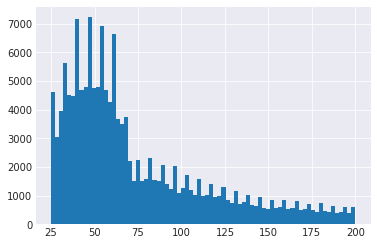

In [12]:
df.text.map(len).hist(bins=75);

In [13]:
random.sample(df.text.tolist(), 10)

['Regional Organisations DCNL - Filtered subset of Organisations',
 'Return a concise string representation of the ``ProbabilisticDependencyGrammar``',
 'tests that if_exists on models delete works as expected',
 "Retrieves a feed containing all of a user\\'s accounts and profiles.",
 'Returns a dict of all pools on all hosts HostManager knows about.',
 'Series plugin: timeframe quality appears, stop waiting, proper appears',
 'Get the configuration data',
 'shows the amount ever received by a given address.',
 'Provision a single machine',
 'Autoreleased version of CFSTR']

## Save

In [14]:
args.save_path = 'docstring_data_text.hdf5'

In [15]:
%time df.to_hdf(args.save_path, 'df', mode='w', format='t', complevel=9)

CPU times: user 18.3 s, sys: 112 ms, total: 18.4 s
Wall time: 18.4 s


In [16]:
!du -sh $args.save_path

9.1M	docstring_data_text.hdf5


## End

In [17]:
args

{'chars_threshold': 0.8,
 'desc_paths': ['./code-docstring-corpus/V2/parallel/parallel_desc',
  './code-docstring-corpus/V2/parallel/parallel_methods_desc'],
 'len_lb': 25,
 'len_up': 200,
 'log_step': 5000,
 'max_descs': 1000000,
 'methods_desc_path': './code-docstring-corpus/V2/parallel/parallel_methods_desc',
 'save_path': 'docstring_data_text.hdf5',
 'toplevelfuncs_desc_path': './code-docstring-corpus/V2/parallel/parallel_desc'}